<font size = 7>DELE ST1504 CA2 Part A: Generative Adversarial Network </font>
<hr>
<font size = 4>
Name: Lee Hong Yi & Yadanar Aung<br>
Admin No: 2223010 & 2214621<br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

**Objective:**  
Develop a <u>Generative Adversarial Network (GAN) model</u> for <u>image generation</u>, utilizing the <u>CIFAR10 dataset</u>. The model aims to generate <u>1000 high-quality, small color images</u> in <u>10 distinct classes</u>, showcasing its ability to learn and replicate complex visual patterns.

**Background:**  
GANs are a revolutionary class of artificial neural networks used in unsupervised machine learning tasks. They consist of two parts: a Generator, which creates images, and a Discriminator, which evaluates them. The objective is to train a GAN that excels in producing diverse, realistic images that closely mimic the characteristics of the CIFAR10 dataset.

**Key Features:** <br>
<u>Implement and evaluate different GAN architectures</u> to determine the most effective model for the CIFAR10 specific image generation task, which should generate images that not only are visually appealing and realistic but also display a wide range of creativity within the constraints of the 10 classes in the dataset.

**Output Specification:**  
The model will produce images that are evaluated based on their similarity to the real images in the CIFAR10 dataset and their diversity across the dataset's classes. The performance of the GAN will be a crucial indicator of its effectiveness in learning and replicating complex patterns from a given dataset.

<hr>
<font size = 5>Performing initial set-up</font>
<hr>

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Input, Activation, GlobalMaxPooling2D, Conv2DTranspose, PReLU
#from tensorflow_addons.layers import SpectralNormalization

import GAN_function as gnnf

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)     
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(0)  

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        print(tf.config.experimental.get_device_details(gpu))
    except:
        pass
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

{'device_name': 'NVIDIA GeForce RTX 3050 Laptop GPU', 'compute_capability': (8, 6)}
There are 1 GPU(s) present.


<hr>
<font size = 5>Background Research</font>
<hr>

**CIFAR10 Dataset:**  
- The CIFAR10 (Canadian Institute for Advanced Research) dataset consists of <u>60,000 colour images</u> in <u>10 classes</u>. 
- There are 6,000 images per class.

**Images:**  
- The images are split into <u>50,000 train images</u> and <u>10,000 test images</u>.
- The images are of <u>size 32x32</u>.

**Classes:**  
- Total of 10 distinct classes:
    1. airplane
    2. automoblie
    3. bird
    4. cat
    5. deer
    6. dog
    7. frog
    8. horse
    9. ship
    10. truck
- Classes are mutually exclusive. 
    - There is no overlap between automobiles and trucks, neither includes pickup trucks.
    - "Automobile" includes sedans, SUVs, etc. 
    - "Truck" includes only big trucks.

**Batches:**  
- The dataset is divided into 5 train batches & 1 test batch, each with 10,000 images.
- Train batches contain 50,000 images in total from each class in random order
    - Some batches contain more images from one class than another
- Test batch contains 10,000 randomly-selected images from each class

**Source:**
https://www.cs.toronto.edu/~kriz/cifar.html

<hr>
<font size = 5>Load CIFAR10 Dataset</font>
<hr>
It returns two tuples: (x_train, y_train), (x_test, y_test). The first element of each tuple is an array of images. The second element is an array of corresponding labels.

x_train: uint8 NumPy array of grayscale image data with shapes (50000, 32, 32, 3), containing the training data. Pixel values range from 0 to 255.

y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (50000, 1) for the training data.

x_test: uint8 NumPy array of grayscale image data with shapes (10000, 32, 32, 3), containing the test data. Pixel values range from 0 to 255.

y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000, 1) for the test data.

Source: https://keras.io/api/datasets/cifar10/

In [5]:
# Load CIFAR10 Dataset
cifar10 = tf.keras.datasets.cifar10.load_data()

<h3>Split into Train Dataset</h3>

In [45]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10

# Concatenate the X_train and X_test
X_train = np.concatenate((X_train, X_test), axis=0)

# Concatenate the y_train and y_test
y_train = np.concatenate((y_train, y_test), axis=0)

# Print the shapes of the combined datasets
print(f"Shape of combined X (features): {X_train.shape}")
print(f"Shape of combined y (labels): {y_train.shape}")

mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))

X_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))

Shape of combined X (features): (60000, 32, 32, 3)
Shape of combined y (labels): (60000, 1)


<font size = 5>Class Labels</font>

In [22]:
# Map integer class labels to their corresponding class names 
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

<hr>
<font size = 5>Exploratory Data Analysis (EDA)</font>
<hr>

### Tips
<s>1. *Visualize Images*: Display a sample of images from each of the 10 classes to understand the variety and quality of images in the dataset.</s>

<s>2. *Class Distribution*: Check if the dataset is balanced across different classes.</s>

<s>3. *Pixel Distribution*: Analyze the distribution of pixel values across the entire dataset and within each class to understand the color distribution.</s>

<s>4. *Image Size and Resolution Analysis*: CIFAR-10 images are 32x32, but it's good to visualize and understand this small resolution's impact.</s>

5. *Correlation Analysis*: Assess if there are any interesting correlations between different color channels.

6. *Data Augmentation Impact*: Visualize how different data augmentation techniques (like rotation, flipping, scaling) affect the images.

<font size = 5>Class Distribution</font>

In [17]:
eda_data = X_train

In [18]:
classes, counts = np.unique(y_train, return_counts=True)
class_count_dict = dict(zip(class_names, counts))
df = pd.DataFrame({'Count': class_count_dict})
df

,Count
Airplane,6000
Automobile,6000
Bird,6000
Cat,6000
Deer,6000
Dog,6000
Frog,6000
Horse,6000
Ship,6000
Truck,6000


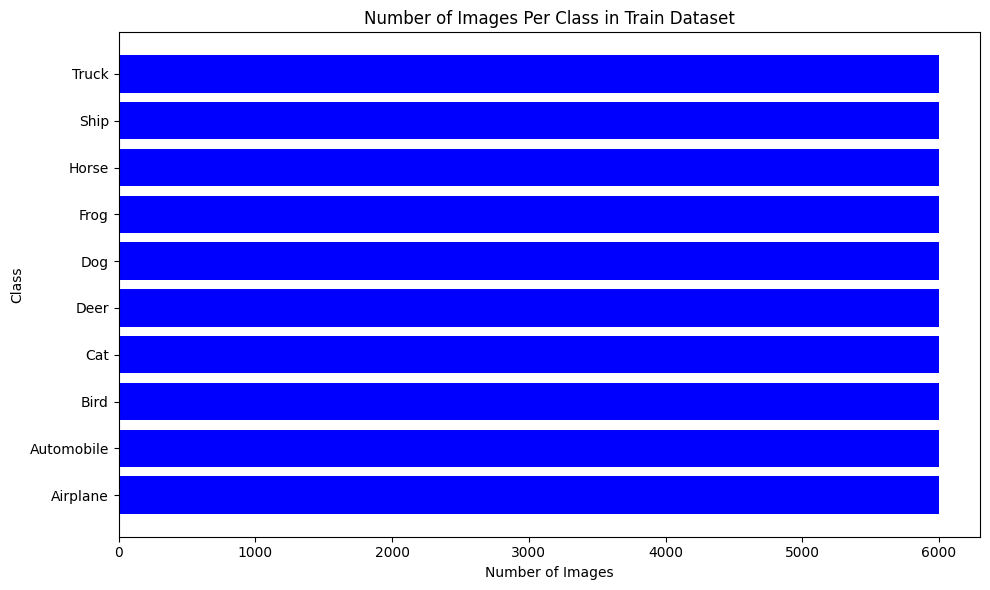

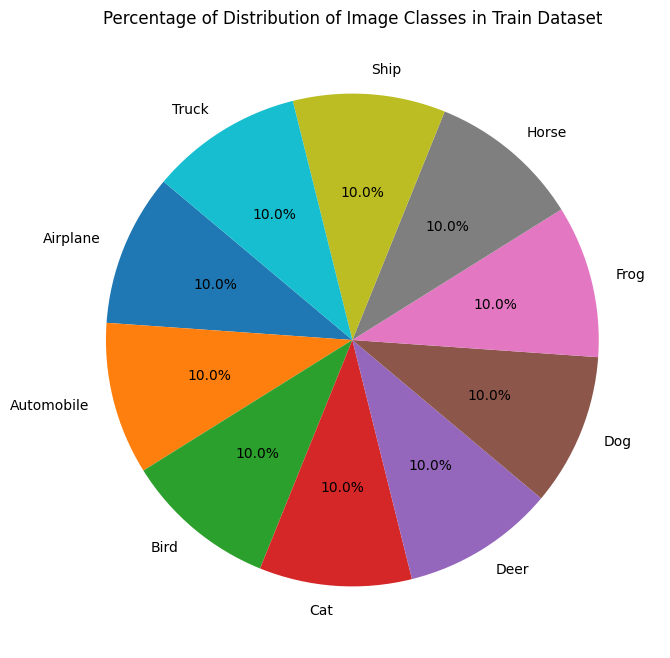

In [19]:
# Visualise Distribution of Image Classes
gnnf.plot_counts(class_count_dict)
gnnf.plot_pie_chart(class_count_dict)

<u>Insights:</u>

Training dataset is balanced.

<font size = 5>Dataset Visualization</font>

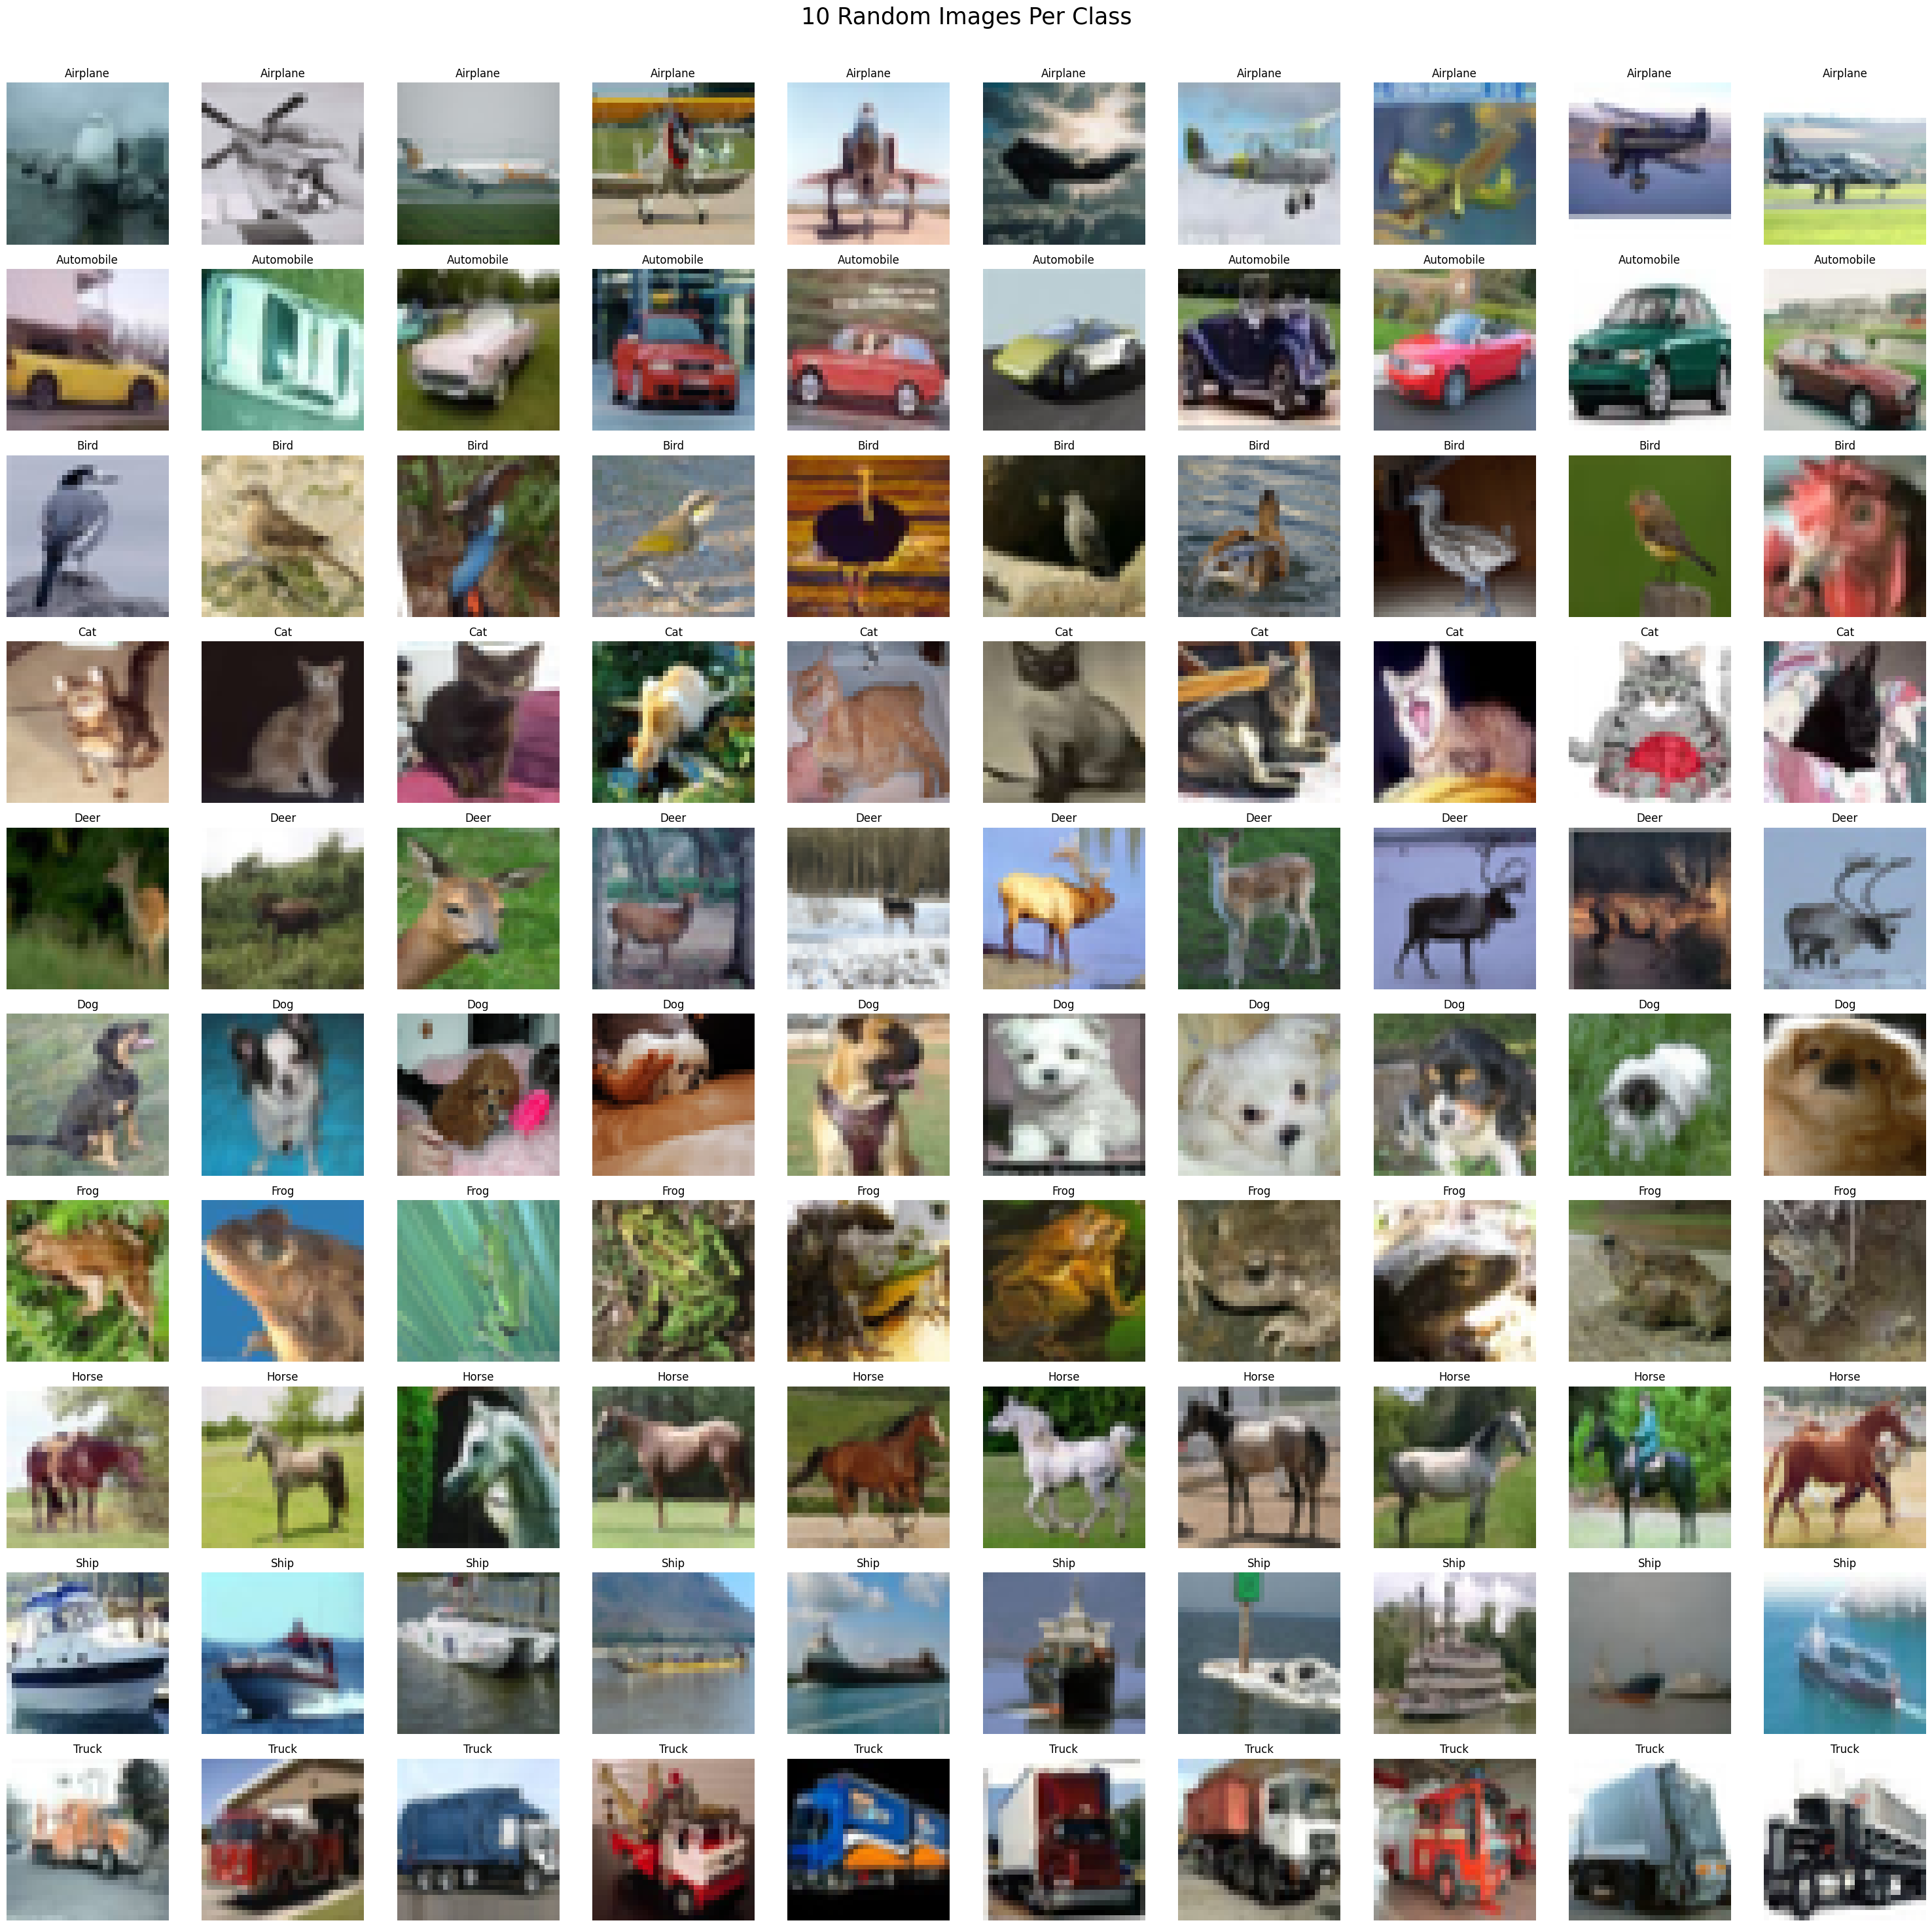

In [20]:
# Create figure & set size
fig, axes = plt.subplots(10, 10, figsize=(30, 30))

for i in range(len(class_names)):
    class_indices = np.where(y_train == i)[0]
    # Randomly select ten images
    random_indices = np.random.choice(class_indices, 10, replace=False)

    for j, image_index in enumerate(random_indices):
        axes[i, j].imshow(eda_data[image_index])
        # Load image
        axes[i, j].axis('off')
        axes[i, j].set_title(class_names[i])

plt.suptitle('10 Random Images Per Class', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<u>Insights:</u>

- variety and quality of images
- image size & resolution analysis
    - understand small resolution's impact

<font size = 5>Image Averaging for Pixel Distribution</font>

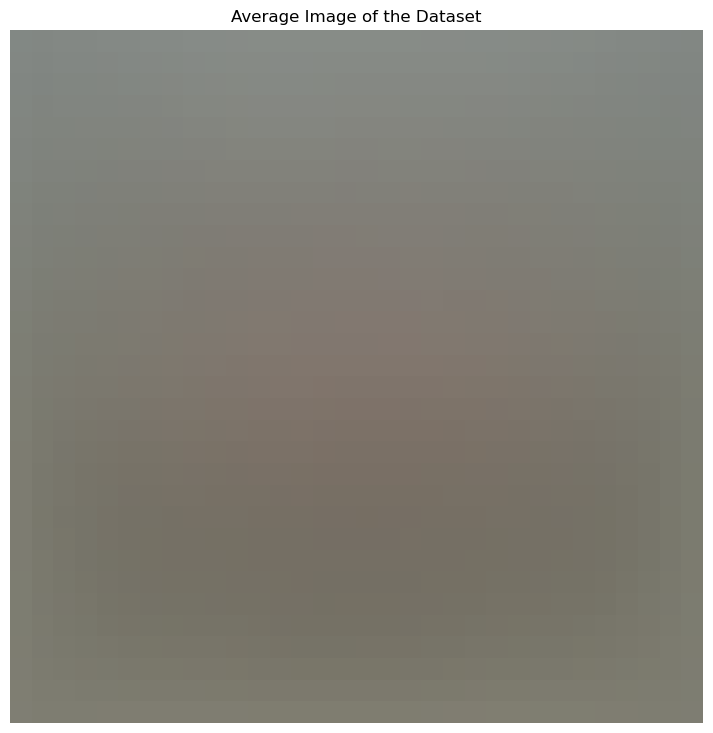

In [ ]:
gnnf.average_image(eda_data)

<u>Insights:</u>

- understand color distribution

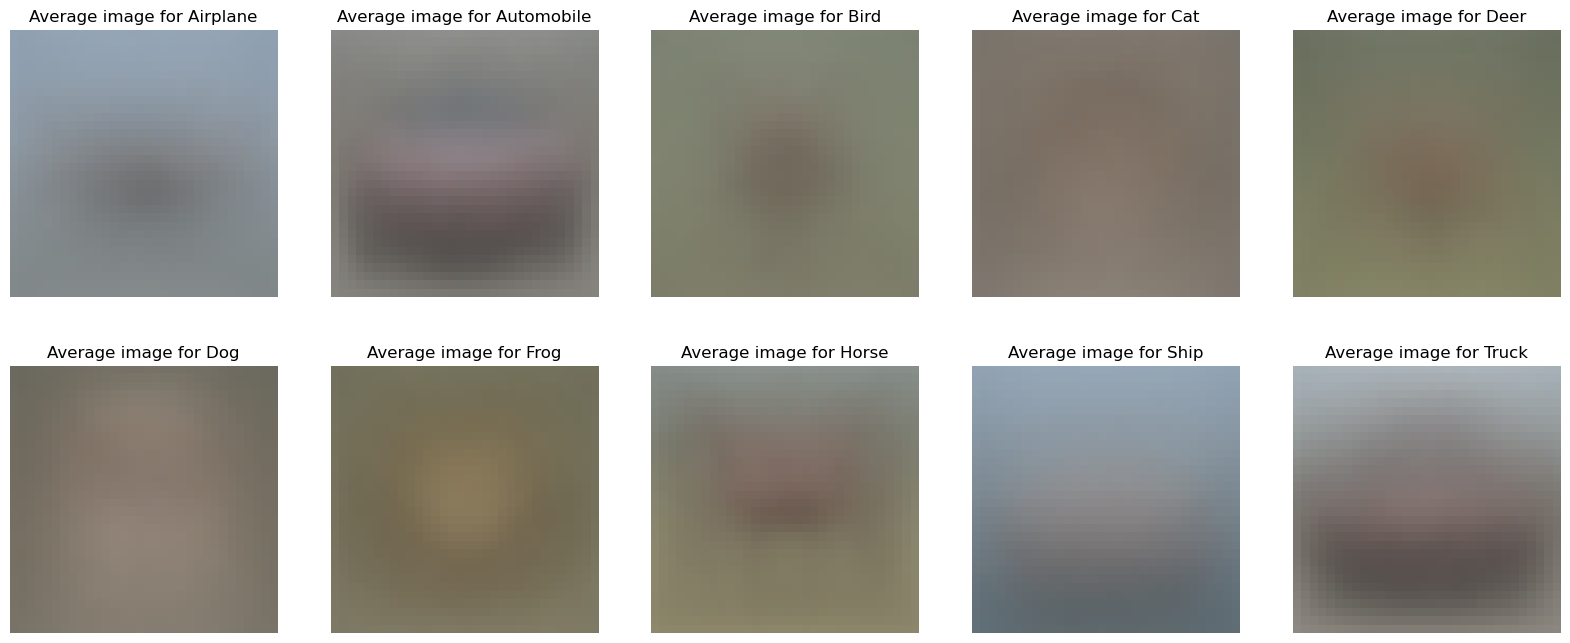

In [ ]:
gnnf.average_images_per_class(eda_data, y_train, class_names)

<u>Insights:</u>

- understand color distribution

<hr>
<font size = 5>Feature Engineering</font>
<hr>

### Tips
1. *Normalization*: Scale pixel values to a range (e.g., 0 to 1 or -1 to 1) to help the model train more efficiently.
2. *Color Space Conversion*: Experiment with different color spaces (like HSV or grayscale) to see if they impact the GAN's performance.
3. *Edge Detection*: Implement edge detection (like the Sobel filter) to create features that emphasize shapes and borders in images.
4. *Noise Addition*: For robustness, you can add small amounts of noise to the input images.
5. *Data Augmentation*: Use techniques like flipping, cropping, or rotating to artificially expand the training dataset.
6. *Dimensionality Reduction*: Experiment with techniques like PCA to reduce the number of input features while retaining essential information.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

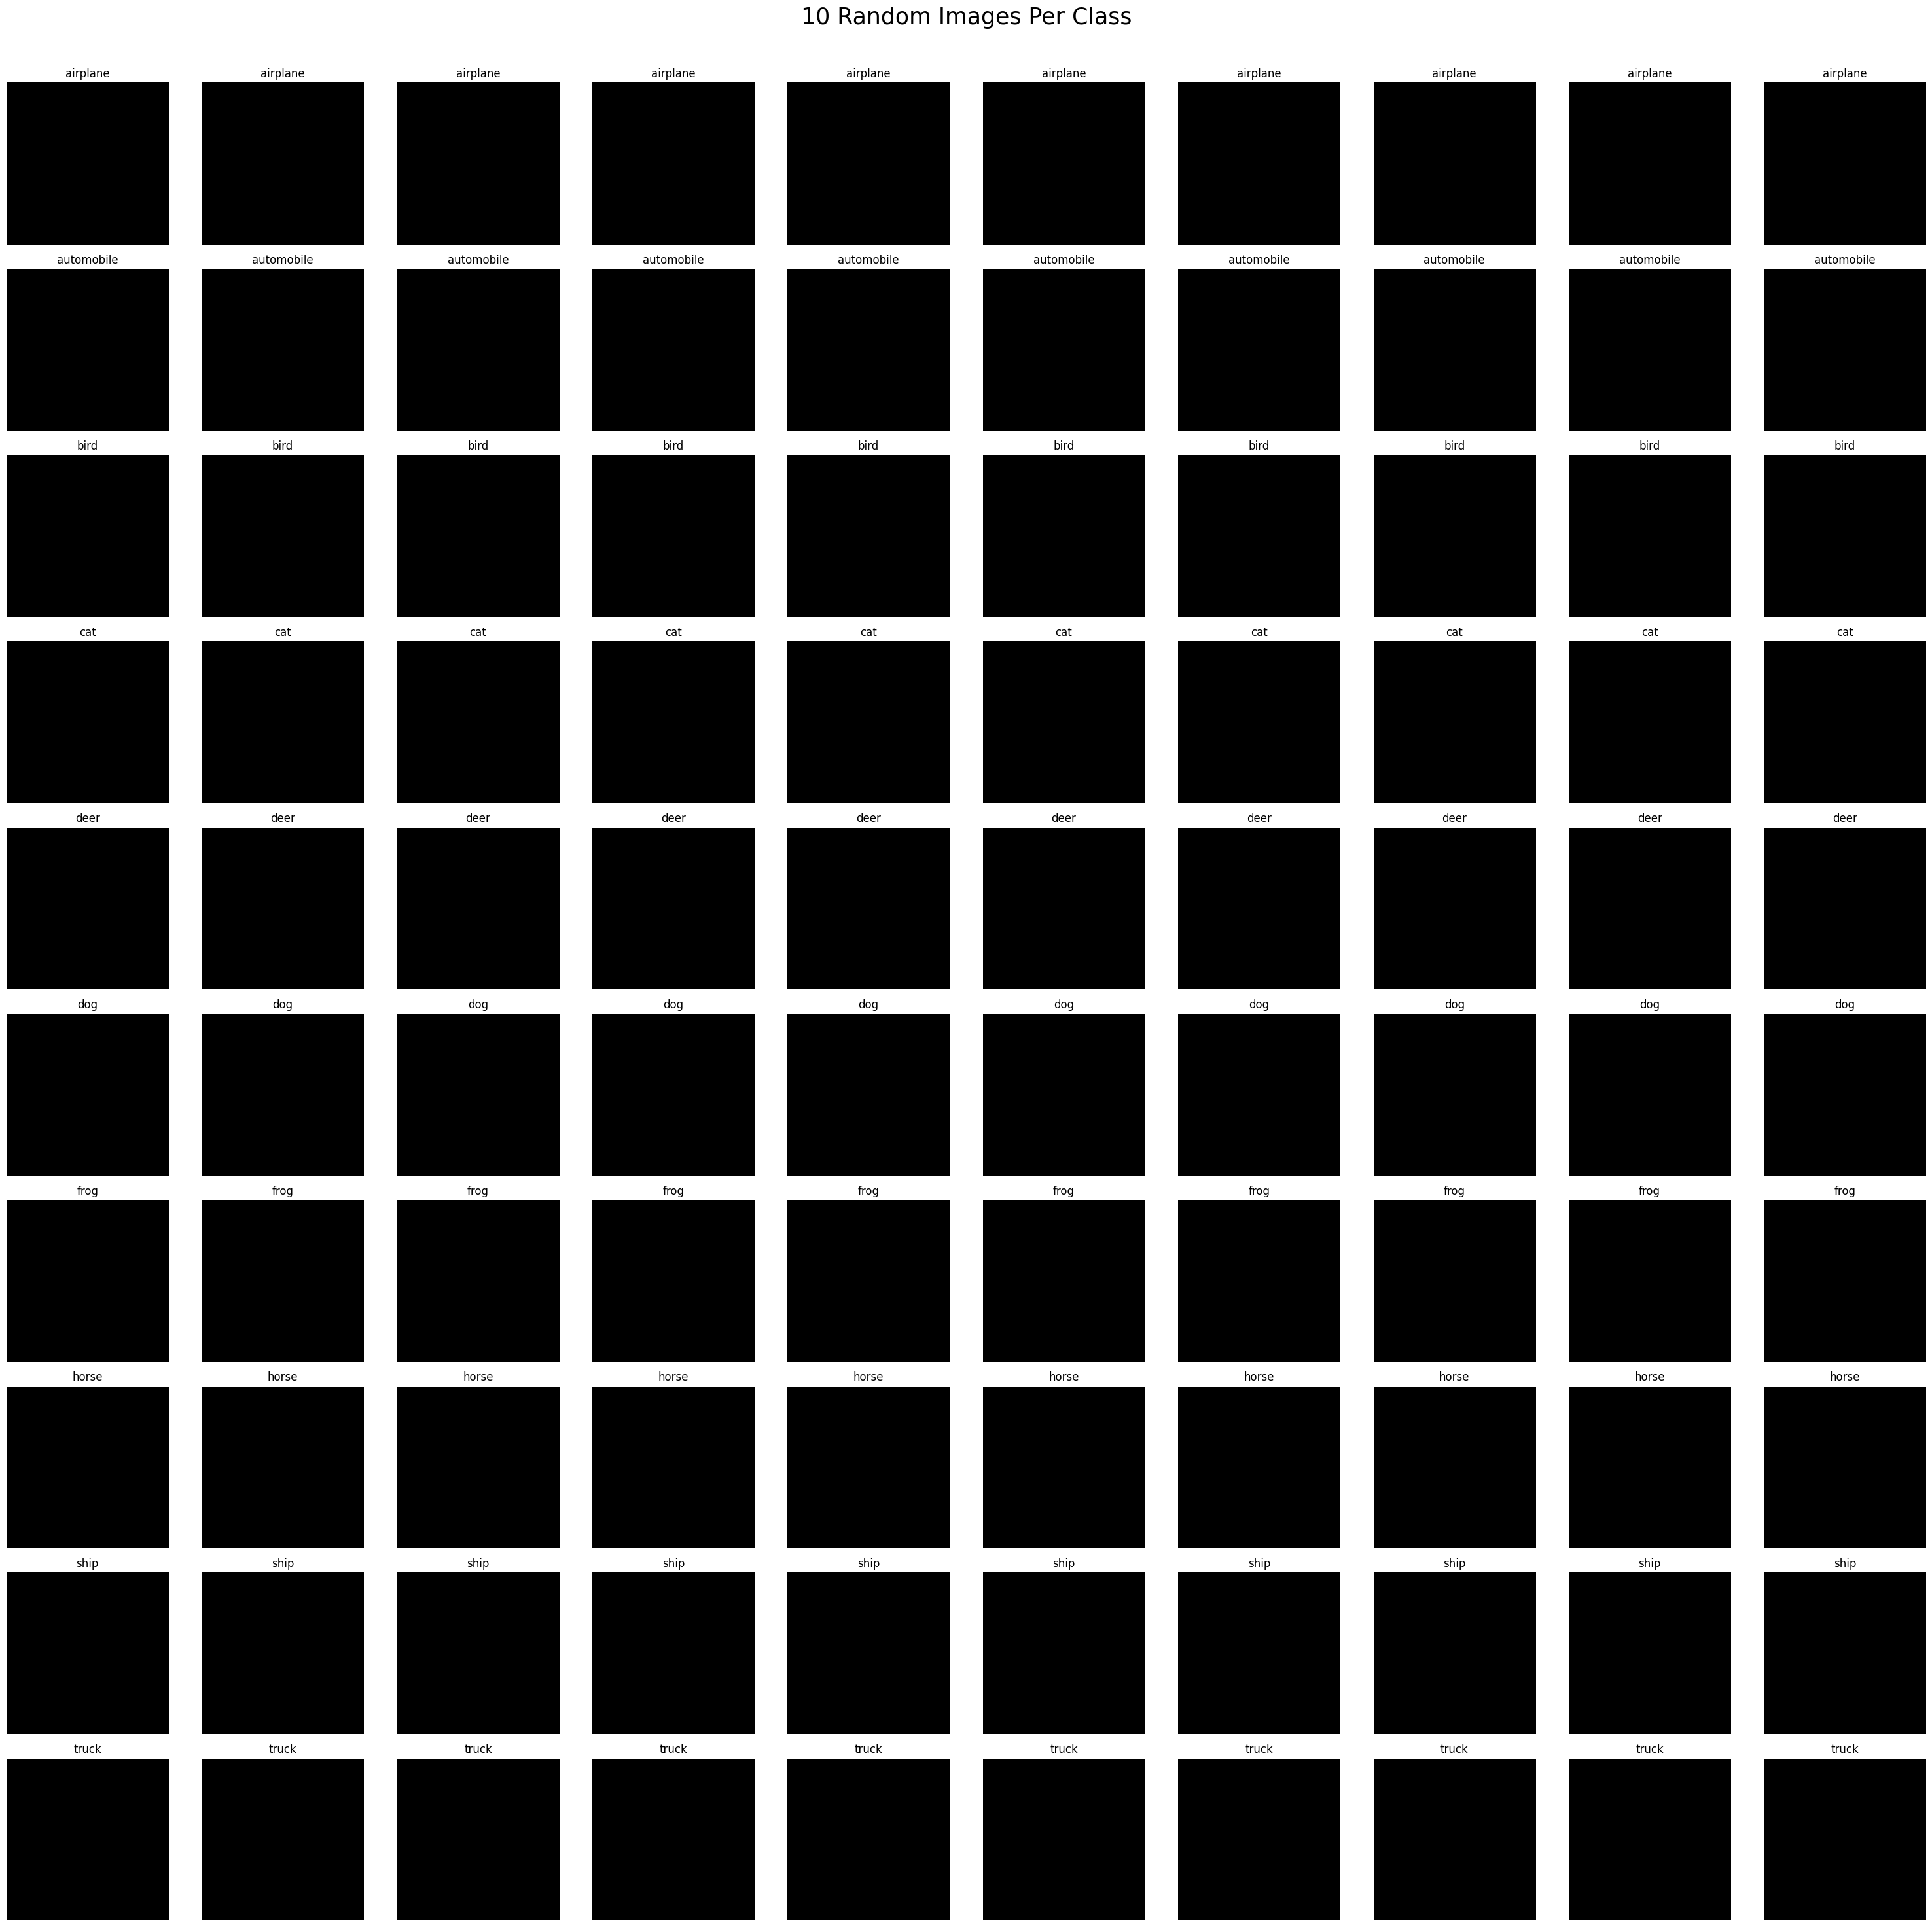

In [44]:
# Define the standardization function
def normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

def standardize_image(image, label, mean, std):
    image = tf.cast(image, tf.float32)
    image = (image - mean) / std
    return image, label

# Create TensorFlow Dataset objects
# Apply the standardization function to the dataset
X_train = X_train.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
X_train = X_train.map(lambda x, y: standardize_image(x, y, mean, std), num_parallel_calls=tf.data.experimental.AUTOTUNE)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 10
class_samples = {class_name: [] for class_name in class_names}

for image, label in X_train.as_numpy_iterator():
    # Extracting the scalar label value
    label = label[0]
    class_name = class_names[label]
    if len(class_samples[class_name]) < samples_per_class:
        class_samples[class_name].append(image)

# Plotting the images
fig, axes = plt.subplots(10, 10, figsize=(30, 30))

for i, class_name in enumerate(class_names):
    for j in range(samples_per_class):
        axes[i, j].imshow(class_samples[class_name][j])
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)

plt.suptitle('10 Random Images Per Class', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<hr>
<font size = 5>Initial Modelling</font>
<hr>

<h3><b>Understanding Generative Adversarial Networks (GAN)</b></h3>

GANs are an approach to generative modelling using deep learning methods, like CNNs.

GANs train a generative model by approaching the problem as a supervised learning problem with two sub-models:
1. <b>Generator</b>: Learn to generate plausible new data from random noise
2. <b>Discriminator</b>: Tries to distinguish real data from fake (generated) data<br>
<img src='https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg' style="background-color:white;" width="500" 
     height="300" >

<h3><b>Training Process</b></h3>

These two models are trained together in a zero-sum game, until the Disciminator is fooled about half the time.

The Generator <u>generates a batch of samples</u>, and along with real samples from the dataset, are provided to the Discriminator to be <u>classified as real (+ve) or fake (-ve)</u>.

While one model trains, the other model's weights remain constant, otherwise the Generator would be trying to hit a moving target & might never converge. The training proceeds in <u>alternating periods</u>, where each model take turns training for one or more epochs.

<h3><b>Loss Functions</b></h3>

Loss functions reflect the distance between the distribution of generated data and the distribution of real data.

Through backpropagation, the Discriminator's weights are updated from the <u>discriminator loss</u> to get better at discriminating, while the Generator's weights are updated from the <u>generator loss</u> based on how well or not the generated samples fool the Discriminator.

Zero-sum game refers to when the Discriminator successfully identifies the real and fake samples, it is <u>rewarded or no change is needed to the model parameters</u>, whereas the <u>the Generator is penalized with large updates to the model parameters</u>, and vice versa.

<h3><b>Convergence</b></h3>

At a limit, the Discriminator cannot tell the difference between perfect replicas and the real images, hence predicts "unsure" (e.g. 50% for real and fake). If the GAN continues training with random feedback from the Discriminator, the model might collapse.

For a GAN, convergence is often a fleeting, rather than stable, state.

<h3><b>Wasserstein Loss</b></h3>

This loss function is based on the modification of the GAN scheme (Wasserstein GAN), where the Discriminator does not actually classify the samples.

Instead for each instance it outputs a number. This number does not have to be less than one or greater than 0, so we cannot use 0.5 as a threshold to decide if a sample if real or fake. Discriminator training tried to make the output bigger for real samples.

<u>Critic Loss: D(x) - D(G(z))</u>

The Discriminator tries to maximize this function, which is the difference between its output on real data and fake data.

<u>Generator Loss: D(G(z))</u>

The Generator tries to maximize this function, which is the Discriminator's output for its fake data.

The justification got WGAN requires the weights throughout GAN be clipped to remain within a constrained range.

This avoids problems with vanishing gradients.

Source: https://developers.google.com/machine-learning/gan/gan_structure

<h3><b>Potential Models</b></h3>

1. DCGAN
2. cGAN
3. SAGAN

Early Stopping to identify when the model collapses

<h3>GAN Template Class to perform inheritance</h3>

In [ ]:
class CustomCallback(Callback):
    def __init__(self, d_losses, g_losses, model, filepath):
        super(CustomCallback, self).__init__()
        self.d_losses = d_losses
        self.g_losses = g_losses
        self.model = model
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        gan_model = self.model
        generator = gan_model.generator
        d_loss = logs.get('d_loss')
        g_loss = logs.get('g_loss')
        self.d_losses = np.array(list(self.d_losses))
        self.g_losses = np.array(list(self.g_losses))
        self.d_losses = np.append(self.d_losses, d_loss)
        self.g_losses = np.append(self.g_losses, g_loss)
        generated_images, generated_labels = gan_model.generate_fake_samples(self.model, generator = generator)
        self.model.save_plot(generated_images, epoch, self.d_losses, self.g_losses, self.filepath)
        self.model.save_weights(f"{self.filepath}weights/weights_{epoch}.h5")


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.metrics import Mean


class GAN_template(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.discriminator = self.define_discriminator()
        self.generator = self.define_generator(latent_dim)
        self.latent_dim = latent_dim
        self.d_loss_tracker = Mean(name="d_loss")
        self.g_loss_tracker = Mean(name="g_loss")
        self.g_loss_list = []
        self.d_loss_list = []

    @staticmethod
    def save_plot(examples, epoch, d_losses, g_losses, filepath):
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(4, 6, height_ratios=[1, 1, 1, 1.2], width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.4, wspace=0.4)
        examples = (examples + 1) / 2.0
        for i in range(3 * 6):
            ax = fig.add_subplot(gs[i // 6, i % 6])
            ax.axis('off')
            ax.imshow(examples[i])
        ax_loss = fig.add_subplot(gs[3, 0:3])
        ax_loss.plot(d_losses, label="Discriminator Loss")
        ax_loss.set_title("Discriminator Loss")
        ax_g_loss = fig.add_subplot(gs[3, 3:6])
        ax_g_loss.plot(g_losses, label="Generator Loss")
        ax_g_loss.set_title("Generator Loss")
        plt.suptitle(f"Epoch {epoch+1}", fontsize=18, y=0.92)
        plt.tight_layout()
        plt.savefig(f"{filepath}generated/generated_plot_e{epoch+1}.png", bbox_inches='tight')
        plt.close()

    @staticmethod
    def generate_fake_samples(self, generator, n_samples=18, latent_dim=100):
        x_input = np.random.randn(latent_dim * n_samples)
        x_input = x_input.reshape(n_samples, latent_dim)
        X = generator.predict(x_input, verbose=0)
        y = np.zeros((n_samples, 1))
        return X, y
    
    def define_discriminator(self, in_shape=(32,32,3)):
        pass

    def define_generator(self, latent_dim):
        pass

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

<h3>1. DCGAN</h3>

In [ ]:
class DCGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)

    def define_discriminator(self, in_shape=(32,32,3)):
        model = Sequential()
        model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer = Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
        return model

    def define_generator(self, latent_dim):
        model = Sequential()
        n_nodes = 256 * 4 * 4
        model.add(Dense(n_nodes, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 256)))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
        return model

dcgan = DCGAN(latent_dim=100)
dcgan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)
dcgan_callback = CustomCallback(d_losses = dcgan.d_loss_list, g_losses = dcgan.g_loss_list, model = dcgan, filepath = "output/models/dcgan/")
dcgan.fit(X_train, epochs = 200, callbacks = [dcgan_callback])


Epoch 1/200
1563/1563 [==============================] - 40s 25ms/step - d_loss: 2.1450 - g_loss: 2673.5793
Epoch 2/200
1563/1563 [==============================] - 40s 26ms/step - d_loss: 0.6269 - g_loss: 14.0183
Epoch 3/200
1563/1563 [==============================] - 39s 25ms/step - d_loss: 0.6257 - g_loss: 7.1585
Epoch 4/200
1563/1563 [==============================] - 39s 25ms/step - d_loss: 0.5607 - g_loss: 5.1244
Epoch 5/200
1563/1563 [==============================] - 39s 25ms/step - d_loss: 0.5882 - g_loss: 4.2982
Epoch 6/200
1563/1563 [==============================] - 39s 25ms/step - d_loss: 0.6747 - g_loss: 3.4099
Epoch 7/200
1563/1563 [==============================] - 40s 25ms/step - d_loss: 0.5902 - g_loss: 2.4917
Epoch 8/200
1563/1563 [==============================] - 40s 26ms/step - d_loss: 0.6001 - g_loss: 2.6006
Epoch 9/200
1563/1563 [==============================] - 39s 25ms/step - d_loss: 0.6088 - g_loss: 1.7812
Epoch 10/200
1563/1563 [===========================

In [ ]:
input_folder = './output/models/dcgan/generated/'  # Replace with your frames directory
output_file = 'output_video.mp4'      # Replace with your desired output file path
gnnf.create_video_from_frames(input_folder, output_file)

<h3>2. cCGAN</h3>

In [ ]:
class cGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)

    def define_discriminator(self, in_shape=(32,32,3)):
        model = Sequential()

        return model

    def define_generator(self, latent_dim):
        model = Sequential()
        
        return model

cgan = cGAN(latent_dim=100)
cgan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)
cgan_callback = CustomCallback(d_losses = cgan.d_loss_list, g_losses = cgan.g_loss_list, model = cgan, filepath = "output/models/cgan/")
cgan.fit(X_train, epochs = 200, callbacks = [cgan_callback])


<h3>3. SAGAN</h3>

In [ ]:
class SAGAN(GAN_template):
    def __init__(self, latent_dim):
        super().__init__(latent_dim)

    def define_discriminator(self, in_shape=(32,32,3)):
        model = Sequential()

        return model

    def define_generator(self, latent_dim):
        model = Sequential()
        return model    

sagan = SAGAN(latent_dim=100)
sagan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)
sagan_callback = CustomCallback(d_losses = sagan.d_loss_list, g_losses = sagan.g_loss_list, model = sagan, filepath = "output/models/sagan/")
sagan.fit(X_train, epochs = 200, callbacks = [cgan_callback])


<hr>
<font size = 5>Model Improvement</font>
<hr>

Tip from Mr Saw:<br>
To improve convergence/avoid overfitting: train discriminator k steps, then generator 1 step, etc. so that discriminator is maintained near optimal.

### Miscellaneous
- *Hyperparameter Tuning*: Experiment with different architectures and training parameters.
- *Loss Function Analysis*: Explore various loss functions and their impact on the generated images' quality

### Advanced Techniques
1. *Feature Learning with Autoencoders*: Use autoencoders to learn compressed representations of the images, which might help in generating new images.
2. *Generative Feature Extraction*: Experiment with using features extracted from other pretrained models as inputs to your GAN.

<hr>
<font size = 5>Result Evaluation</font>
<hr>

### Evaluation Metrics
- *FID Score*: Use the Fréchet Inception Distance to evaluate the quality of images generated by your GAN.
- *Visual Inspection*: Regularly sample and inspect generated images to qualitatively assess the model's performance.

In [ ]:
#i fucking hate fid and inception score why the fuck do i need an inception model knnccb make my life so difficult cbdog can i just use my fucking cnn model anot its alr ufkcing inception net cb dog fucking hell bro i cant do this anymore can i jsut use Kl dviercen and call it a day fucking dog sia omg
# STUPID STUPID STUPID STUPID FUCK FUCK FUCK FUCK
# ok 
inceptionModel = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inceptionModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_175 (Conv2D)            (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_175[0][0]']             
 alization)                     )                                                      